#Text Classification

-------------------------------------------------------------

# Information

## Students Information:


1. Student 1
  * Name = Peyman 
  * Last Name = Naseri
  * Student ID = 4011305965014


## Project Information:


* Course: Applied Data Science
* colab: [link](https://colab.research.google.com/github/peyman886/ADS/blob/main/Project/ADS_Project.ipynb#scrollTo=B3DpKgkyzYIC) 
* github: [link](https://github.com/peyman886/ADS/blob/main/Project/ADS_Project.ipynb)

##  Project Subject



<font face="XB Zar" size=5><div dir=rtl>
**جریان‌سازی فکری و فرهنگی خبر**
<br>
در این پروژه هدف پیاده‌سازی یک مدل برای تشخیص جربان‌سازی یک خبر است. خبرهایی که اثرات مهم دارند و
احتمالا باعث ایجاد تحول فرهنگ، اجتماع و از این دست بشوند و در آینده خبرهای مشابه دیگری در رابطه با آن‌ها
منتشر شود را جریان ساز می‌گوییم. براساس داده‌هایی که داریم به پیاده سازی مدل دسته بندی می‌پردازیم.
برای توضیحات بیشتر به تیتر چند خبر و برچسب مربوط به آن خبر توجه فرمایید:
</div>

<center><img src="https://github.com/peyman886/ADS/blob/main/Project/DataL_Photo.jpg?raw=true"/></center>


<table style="border-collapse: collapse;">
            <tr>
                <td style="border: 1px solid #333; padding: 100px; vertical-align: middle;">خبر</td>
                <td style="border: 1px solid #333; padding: 100px; vertical-align: middle;">برچسب</td>
            </tr>
            <tr>
                <td style="border: 1px solid #333; padding: 100px; vertical-align: middle;">عصبانیت شدید مسی از لاپورتا | رئیس بارسلونا تهدید شد</td>
                <td style="border: 1px solid #333; padding: 100px; vertical-align: middle;">غیر جریان ساز</td>
            </tr>
            <tr>
                <td style="border: 1px solid #333; padding: 100px; vertical-align: middle;"></td>
                <td style="border: 1px solid #333; padding: 100px; vertical-align: middle;"></td>
            </tr>
            <tr>
                <td style="border: 1px solid #333; padding: 10px; vertical-align: middle;"></td>
                <td style="border: 1px solid #333; padding: 10px; vertical-align: middle;"></td>
            </tr>
            <tr>
                <td style="border: 1px solid #333; padding: 10px; vertical-align: middle;"></td>
                <td style="border: 1px solid #333; padding: 10px; vertical-align: middle;"></td>
            </tr>
            <tr>
                <td style="border: 1px solid #333; padding: 10px; vertical-align: middle;"></td>
                <td style="border: 1px solid #333; padding: 10px; vertical-align: middle;"></td>
            </tr>
    </table>

# Setting gpu

for use local gpu run this comand in anaconda prompet and copy url and paste on colab:

    pip install jupyter_http_over_ws
    jupyter serverextension enable --py jupyter_http_over_ws
    jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

https://research.google.com/colaboratory/local-runtimes.html  


In [1]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       # tf.config.experimental.set_virtual_device_configuration(gpu,
#       #                                                         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])

#   except RuntimeError as e:
#     print(e)


# if len(tf.config.list_physical_devices('GPU')) > 0:
#   !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

# Required libraries

Install & import required libraries

In [3]:
%%capture
!pip install Levenshtein
!pip install transformers
!pip install hazm

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from tqdm.notebook import tqdm
import nltk
import codecs


from plotly import graph_objs as go
import plotly.express as px

import os

from sklearn.metrics import classification_report


In [5]:
# ! pip install --quiet --upgrade --pre tensorflow

In [6]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

# DATA

## Download Data

In [ ]:
import os.path
if not os.path.isfile('project_dataset.zip'):
  !gdown --id 1TMIVW3yQvVP2AM2vIaQTs9NyR93JZW9S
  !unzip 'project_dataset.zip'
  

## Load data

In [8]:
data = pd.read_json('dataset.json',lines=True)
data


,train,eval,test
0,[{'text': 'آتش سوزی کارخانه جمیل نخ گسترده است...,[{'text': 'نجات از عوارض غذا های فرآوری شده با...,[{'text': 'رکوردشکنی رمزارز دوم ____________ ج...


### Labeling By Voting

In this part, we determine the data label by voting between the labels. If the number of `جریان‌ساز` taggs is more, we will set the label to 1, otherwise it will be 0.

In [9]:
label_dict = {
    'جریان\u200cساز': 1,
    'غیر جریان\u200cساز' : 0
}
labels = list(label_dict.keys())

def func(arr):
  arr = [label_dict[element] for element in arr]
  x = sum(arr)/len(arr)
  if x<=0.5: 
    return 0
  return 1

def labeling(df_name):
  # df_name = df
  df = pd.DataFrame(data[df_name][0])
  df['label'] = df['annotations'].apply(lambda x :func(x) if len(x)>0 else -1)
  df = df[df['label']>=0] # Delete unlabeled data
  df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
  print('max length in', df_name, 'data:', max(df['text_len']))
  return df


In [10]:
l = ['train','eval', 'test']
df_train, df_val, df_test = [labeling(info) for info in l]

max length in train data: 578
max length in eval data: 261
max length in test data: 227


In [11]:
all_df = [df_train, df_val, df_test]
df = pd.concat(all_df)
df

,text,annotations,label,text_len
0,آتش سوزی کارخانه جمیل نخ گسترده است / اعزام نی...,"[غیر جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,97
1,تجهیزات باکیفیت صنعتی آشپزخانه و کافی شاپ\n___...,"[غیر جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,99
2,برگزاری جشنواره رسانه ابوذر در دی ماه سال جاری...,"[جریان‌ساز, جریان‌ساز, جریان‌ساز]",1,114
3,افزایش 80 درصدی فروش سلاح در آمریکا در ژانویه ...,"[جریان‌ساز, غیر جریان‌ساز, جریان‌ساز]",1,116
4,بازداشت دو تروریست که در بمب گذاری مسیر زائران...,"[غیر جریان‌ساز, غیر جریان‌ساز]",0,82
...,...,...,...,...
69,احیای بینایی با ایمپلنت شبکیه\n____________\nش...,[غیر جریان‌ساز],0,86
70,ببینید | شکاک بودن همیشه بد نیست!\n___________...,"[جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,11
71,تدبیر ژاپن برای دستیابی به قابلیت حمله به پایگ...,"[غیر جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,95
72,کشف گونه جدید ویروس کرونا در نیجریه\n_________...,"[جریان‌ساز, غیر جریان‌ساز, جریان‌ساز]",1,99


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> EDA 📊</p>



### Input Sentences Length Distribution

In [ ]:
ham_df = df[df['label'] == 0]['text_len'].value_counts().sort_index()
spam_df = df[df['label'] == 1]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name=labels[0],
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name=labels[1],
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

As we can see, the `غیر جریان‌ساز` message length tend to be lower than `جریان‌ساز` message length.

### Target Distribution

Now we are going to take a look about the target distribution and the messages length.



<center><img src="https://miro.medium.com/max/900/1*zsyN08VVrgHbAEdvv27Pyw.png"/></center>

**Balanced Dataset:** — Let’s take a simple example if in our data set we have positive values which are approximately same as negative values. Then we can say our dataset in balance.


<center><img src="https://miro.medium.com/max/258/1*EZxsI_kDPlZFPPYEG17ZQg.png"/></center>

Consider Orange color as a positive values and Blue color as a Negative value. We can say that the number of positive values and negative values in approximately same.

**Imbalanced Dataset:** — If there is the very high different between the positive values and negative values. Then we can say our dataset in Imbalance Dataset.

<center><img src="https://miro.medium.com/max/518/1*xgdJE0zazGdn15NZinqepA.png"/></center>


In [12]:
balance_counts = df.groupby('label')['label'].agg('count').values
balance_counts

array([1192,  405])

In [13]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=[labels[0]],
    y=[balance_counts[0]],
    name=labels[0],
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=[labels[1]],
    y=[balance_counts[1]],
    name=labels[1],
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study in next section.



## <p style="background-color:skyblue; font-family:newtimeroman; font-size:50%; text-align:center; border-radius: 15px 50px;">Data Pre-processing 🛠</p>



Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

### Resampling

An effective way to handle imbalanced data is to downsample of the majority class.

<ul>
<li><strong>Downsampling</strong>  means training on a disproportionately
low subset of the majority class examples.</li>


In [15]:
df_train_1 = df_train[df_train['label']==1]
df_train_0  = df_train[df_train['label']==0]
print(df_train_1.shape)
print(df_train_0.shape)

(366, 4)
(1082, 4)


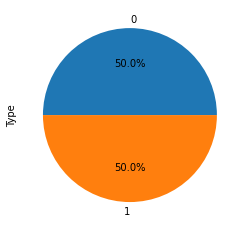

732


In [16]:
from sklearn.utils import resample
def resampling(method, df_train=df_train,df_train_1=df_train_1, df_train_0=df_train_0):  
  if method == 'up_sampleing':
    df_train_1 = resample(df_train_1,
             replace=True,
             n_samples=len(df_train_0),
             random_state=42)
  elif method == 'down_sampleing':
    df_train_0 = resample(df_train_0,
                replace=True,
                n_samples=len(df_train_1),
                random_state=42)

  df_train = pd.concat([df_train_1, df_train_0])


  df_train.groupby('label').size().plot(kind='pie',
                                        y = "v1",
                                        label = "Type",
                                        autopct='%1.1f%%')
  plt.show()
  return df_train

df_train = resampling('down_sampleing') 
print(len(df_train))

### Shuffling

In [17]:
for data_frame in all_df:
  data_frame = data_frame.sample(frac=1).reset_index(drop=True)

### cleaning

In [18]:
from __future__ import unicode_literals
from hazm import * #Python library for digesting Persian text.
import re #This module provides regular expression matching operations similar to those found in Perl.
import string

####اصلاح نویسه ها و استفاده از نیم فاصله

In [ ]:
normalizer = Normalizer() 

#### Scpecific Cleaning

We'll remove the following:

- Hashtags
- HTML
- URLs
- Unicode Special Characters
- User Mentions
- Numbers

In [ ]:
def clean_text(text):
  '''remove text in square brackets,remove links,remove punctuation
  and remove words containing numbers.'''
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

#### Stemming
Words have different forms, i.e., plural for nouns or past tense for words. If we tokenize our corpus as-is, it will result in different tokens for words that mean the same but have taken different forms. To avoid such problems, we'll use hazm's stemmer to replace each word with its non-decorated version.
For example, `کتاب‌ها`'s stemmed form, would be `کتاب`



In [ ]:
stemmer = Stemmer()

#### Stop Words
Stopwords have a very low impact on meaning, but have high usage frequency, so removing them can be a good idea.

In [ ]:
# Persian Stopwords
# https://github.com/sobhe/hazm/blob/master/hazm/data/stopwords.dat
stop_words = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]


#### hem

In [19]:
def preprocess_data(text):
  
  # normalize all the words in the sentence
  text = ' '.join(normalizer.normalize(word) for word in text.split(' '))

  # Clean puntuation, urls, and so on
  text = clean_text(text)

  # Remove stopwords
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  
  # Stemm all the words in the sentence
  text = ' '.join(stemmer.stem(word) for word in text.split(' '))
  
  return text

In [20]:
def cleaner(df):
  # df['text_clean'] = df['text'].apply(preprocess_data)
  return df
df = cleaner(df)
df

,text,annotations,label,text_len
0,آتش سوزی کارخانه جمیل نخ گسترده است / اعزام نی...,"[غیر جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,97
1,تجهیزات باکیفیت صنعتی آشپزخانه و کافی شاپ\n___...,"[غیر جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,99
2,برگزاری جشنواره رسانه ابوذر در دی ماه سال جاری...,"[جریان‌ساز, جریان‌ساز, جریان‌ساز]",1,114
3,افزایش 80 درصدی فروش سلاح در آمریکا در ژانویه ...,"[جریان‌ساز, غیر جریان‌ساز, جریان‌ساز]",1,116
4,بازداشت دو تروریست که در بمب گذاری مسیر زائران...,"[غیر جریان‌ساز, غیر جریان‌ساز]",0,82
...,...,...,...,...
69,احیای بینایی با ایمپلنت شبکیه\n____________\nش...,[غیر جریان‌ساز],0,86
70,ببینید | شکاک بودن همیشه بد نیست!\n___________...,"[جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,11
71,تدبیر ژاپن برای دستیابی به قابلیت حمله به پایگ...,"[غیر جریان‌ساز, غیر جریان‌ساز, غیر جریان‌ساز]",0,95
72,کشف گونه جدید ویروس کرونا در نیجریه\n_________...,"[جریان‌ساز, غیر جریان‌ساز, جریان‌ساز]",1,99


In [21]:
for data_frame in all_df:
  cleaner(data_frame)

As we eventually decided to use BertTokenizer, we decided to not use those cleaning functions as they have negative impact on our models' performance.



### Tokenizer

**Bert_tokenizer**

The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).Tokenization is breaking the raw text into small chunks. Tokenization breaks the raw text into words, sentences called tokens. These tokens help in understanding the context or developing the model for the NLP. The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words.
For example, the text "هوا بارانی است" can be tokenized into 'هوا', 'بارانی', 'است'

There are different methods to perform tokenization. We encode the data using Bert Tokenize

In [22]:
#Loading Tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')

In [23]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train.text.values,
    # df_train.text_clean.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,

    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_val.text.values,
    # df_val.text_clean.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,

    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df_test.text.values,
    # df_test.text_clean.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,

    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)
x_train = input_ids_train.numpy()
y_train = labels_train.numpy()

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_val.label.values)
x_val = input_ids_val.numpy()
y_val = labels_val.numpy()

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df_test.label.values)
x_test = input_ids_test.numpy()
y_test = labels_test.numpy()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



### Data Loaders

In [24]:
## Encoding Data
from torch.utils.data import TensorDataset

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)

dataset_test = TensorDataset(input_ids_test, 
                            attention_masks_test,
                           labels_test)

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=32
)

# MODELS

## Classic Models

### <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Naive Bayes</p>


<center><img src="https://biol607.github.io/lectures/images/bayes/data-science-bayes-theorem-2.jpg"/></center>

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.


#### Define & Train

In [26]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(x_train, y_train)

MultinomialNB()

#### Test

In [27]:
predictions = nb.predict(x_test)
r = classification_report(y_test, predictions)
print(r)

              precision    recall  f1-score   support

           0       0.75      0.85      0.80        54
           1       0.38      0.25      0.30        20

    accuracy                           0.69        74
   macro avg       0.57      0.55      0.55        74
weighted avg       0.65      0.69      0.67        74



It is clear that during testing, due to the weakness of the model, very good results are not obtained:

### XGBoost



<center><img src="https://github.com/peyman886/ADS/blob/main/Project/Flow-chart-of-XGBoost.png?raw=true"/></center>

**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.


In [28]:
# ! pip install xgboost

In [29]:
from sklearn.metrics import accuracy_score
import pickle
from matplotlib import pyplot

from xgboost import XGBClassifier
import xgboost as xgb

#### define Model

In [30]:
model = XGBClassifier(
    objective='binary:logistic',
    tree_method = 'gpu_hist',
    n_jobs=-1,
    n_estimators=100,
    # max_depth=16,
    max_depth=8,
    # colsample_bytree=0.8, 
    # subsample=0.8, 
    learning_rate=0.1,
    # learning_rate=0.2,
    # min_child_weight=6,
)

#### Training

In [31]:
model.fit(
    x_train, 
    y_train, 
    eval_metric=['logloss'], 
    eval_set=[(x_train, y_train), (x_val, y_val)], 

    verbose=True, 
    early_stopping_rounds = 20
)

[0]	validation_0-logloss:0.640089	validation_1-logloss:0.69716
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.598323	validation_1-logloss:0.684
[2]	validation_0-logloss:0.563266	validation_1-logloss:0.679552
[3]	validation_0-logloss:0.528878	validation_1-logloss:0.695305
[4]	validation_0-logloss:0.496929	validation_1-logloss:0.704149
[5]	validation_0-logloss:0.464225	validation_1-logloss:0.71074
[6]	validation_0-logloss:0.437304	validation_1-logloss:0.718768
[7]	validation_0-logloss:0.409941	validation_1-logloss:0.725884
[8]	validation_0-logloss:0.388455	validation_1-logloss:0.73354
[9]	validation_0-logloss:0.366876	validation_1-logloss:0.743713
[10]	validation_0-logloss:0.342155	validation_1-logloss:0.75516
[11]	validation_0-logloss:0.324027	validation_1-logloss:0.761113
[12]	validation_0-logloss:0.303348	validation_1-logloss:0.768718
[13]	va

XGBClassifier(max_depth=8, n_jobs=-1, tree_method='gpu_hist')

#### evaluation

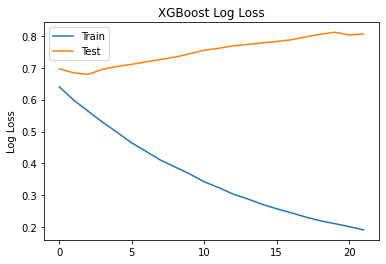

In [32]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

#### Test

In [33]:
# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

r = classification_report(y_test, predictions)
print(r)

              precision    recall  f1-score   support

           0       0.68      0.48      0.57        54
           1       0.22      0.40      0.29        20

    accuracy                           0.46        74
   macro avg       0.45      0.44      0.43        74
weighted avg       0.56      0.46      0.49        74



## Deep Model

### BERT

<center><img src="https://github.com/peyman886/ADS/blob/main/Project/new_BERT_Overall.jpg?raw=true"/></center>


The **BERT** model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.


The abstract from the paper is the following:
*We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.*




#### Pretrained Model



[ParsBERT](https://arxiv.org/abs/2005.12515) is a monolingual language model based on Google’s BERT architecture. This model is pre-trained on large Persian corpora with various writing styles from numerous subjects (e.g., scientific, novels, news) with more than 3.9M documents, 73M sentences, and 1.3B words.

In [34]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
                                      'HooshvareLab/bert-fa-base-uncased', 
                                      num_labels = len(label_dict),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

#### Optimizer & Scheduler

In [35]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



#### Performance Metrics

In [36]:

def report_result_classification(preds, labels):
  '''
  report result precision, recall, f1-score on test data
  '''
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  r = classification_report(preds_flat, labels_flat)
  return r

#### Training

In [37]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [39]:
def evaluate(dataloader_val):
  
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [40]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write('\nEpoch {:1d}'.format(epoch))
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, val_predictions, true_vals = evaluate(dataloader_val)
    tqdm.write(f'Validation loss: {val_loss}')
    r = report_result_classification(val_predictions, true_vals)
    tqdm.write(f'\n{r}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6448998289263767


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.6803020238876343

              precision    recall  f1-score   support

           0       0.61      0.81      0.69        42
           1       0.58      0.33      0.42        33

    accuracy                           0.60        75
   macro avg       0.59      0.57      0.56        75
weighted avg       0.59      0.60      0.57        75



Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5157196165426917


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.6228388349215189

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        53
           1       0.47      0.41      0.44        22

    accuracy                           0.69        75
   macro avg       0.62      0.61      0.61        75
weighted avg       0.68      0.69      0.69        75



Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3842369761803876


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.7327632904052734

              precision    recall  f1-score   support

           0       0.61      0.83      0.70        41
           1       0.63      0.35      0.45        34

    accuracy                           0.61        75
   macro avg       0.62      0.59      0.58        75
weighted avg       0.62      0.61      0.59        75



Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2673719502661539


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.9833719531695048

              precision    recall  f1-score   support

           0       0.45      0.86      0.59        29
           1       0.79      0.33      0.46        46

    accuracy                           0.53        75
   macro avg       0.62      0.59      0.52        75
weighted avg       0.66      0.53      0.51        75



Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.1545185328501722


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 1.1458699107170105

              precision    recall  f1-score   support

           0       0.46      0.90      0.61        29
           1       0.84      0.35      0.49        46

    accuracy                           0.56        75
   macro avg       0.65      0.62      0.55        75
weighted avg       0.70      0.56      0.54        75



Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.09807046146496483


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 1.1550928552945454

              precision    recall  f1-score   support

           0       0.55      0.84      0.67        37
           1       0.68      0.34      0.46        38

    accuracy                           0.59        75
   macro avg       0.62      0.59      0.56        75
weighted avg       0.62      0.59      0.56        75



Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.040941926448241524


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 1.4080715576807659

              precision    recall  f1-score   support

           0       0.57      0.82      0.67        39
           1       0.63      0.33      0.44        36

    accuracy                           0.59        75
   macro avg       0.60      0.58      0.56        75
weighted avg       0.60      0.59      0.56        75



Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.031031504374645327


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 1.4656543731689453

              precision    recall  f1-score   support

           0       0.59      0.80      0.68        41
           1       0.58      0.32      0.42        34

    accuracy                           0.59        75
   macro avg       0.58      0.56      0.55        75
weighted avg       0.58      0.59      0.56        75



Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.02005142329827599


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 1.430659294128418

              precision    recall  f1-score   support

           0       0.57      0.82      0.67        39
           1       0.63      0.33      0.44        36

    accuracy                           0.59        75
   macro avg       0.60      0.58      0.56        75
weighted avg       0.60      0.59      0.56        75



Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.02238812032358154


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 1.6091087261835735

              precision    recall  f1-score   support

           0       0.57      0.84      0.68        38
           1       0.68      0.35      0.46        37

    accuracy                           0.60        75
   macro avg       0.63      0.60      0.57        75
weighted avg       0.63      0.60      0.57        75



The training results of this model can be seen above, after the completion of each epoch, the model is also evaluated on the validation data.

#### Test

In [41]:
test_loss, test_predictions, true_test = evaluate(dataloader_test)
r = report_result_classification(test_predictions, true_test)
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'\n{r}')

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 1.5982279380162556

              precision    recall  f1-score   support

           0       0.61      0.85      0.71        39
           1       0.70      0.40      0.51        35

    accuracy                           0.64        74
   macro avg       0.66      0.62      0.61        74
weighted avg       0.65      0.64      0.61        74



# References



* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

* [Huggingface Bert Model](https://huggingface.co/HooshvareLab/bert-fa-base-uncased?text=%D8%A7%DB%8C%D9%86+%D8%AF%D8%A7%D9%86%D8%B4%D9%85%D9%86%D8%AF+%5BMASK%5D+%D8%A8%D8%A7%D8%B9%D8%AB+%D8%A7%D9%81%D8%AA%D8%AE%D8%A7%D8%B1+%D8%A7%D8%B3%D8%AA.)
* [transformers.Bert documentation](https://huggingface.co/transformers/model_doc/bert.html)

* [Natural Languague Processing A complete Guide](https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained/notebook)

* [Naive Bayes](https://biol607.github.io/lectures/bayes.html#1)

* [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)